# Sequence-to-sequence (seq2seq) Part I

In A4, you have learnt to use RNN-Encoder, specifically LSTM and its variants with various types of attention, to solve classification problems. In contrast, this assignment will be about the seq2seq (Encoder-Decoder model and a well-known type of attention, self-attention. 

Sequence-to-sequence (seq2seq) models in NLP are used to convert sequences of Type A to sequences of Type B. For example, translation of English sentences to German sentences is a sequence-to-sequence task.

Recurrent Neural Network (RNN) based sequence-to-sequence models have garnered a lot of attraction ever since they were introduced in 2014. Most of the data in the current world are in the form of sequences – it can be a number sequence, text sequence, a video frame sequence or an audio sequence.

The performance of these seq2seq models was further enhanced with the addition of the Attention Mechanism in 2015. How quickly advancements in NLP have been happening in the last 5 years – incredible!

These sequence-to-sequence models are pretty versatile and they are used in a variety of NLP tasks, such as:

* Machine Translation
* Text Summarization
* Speech Recognition
* Question-Answering System, and so on

Example:

![encoder_decoder.png](./images/translate.png)  

The above seq2seq model is converting a German phrase to its English counterpart. Let’s break it down:

* Both Encoder and Decoder are RNNs
* At every time step in the Encoder, the RNN takes a word vector (xi) from the input sequence and a hidden state (Hi) from the previous time step
* The hidden state is updated at each time step
* The hidden state from the last unit is known as the context vector. This contains information about the input sequence
* This context vector is then passed to the decoder and it is then used to generate the target sequence (English phrase)
* If we use the Attention mechanism, then the weighted sum of the hidden states are passed as the context vector to the decoder
 
However, there exists some challenges. Despite being so good at what it does, there are certain limitations of seq-2-seq models with attention:

* Dealing with long-range dependencies is still challenging
* The sequential nature of the model architecture prevents parallelization. These challenges are addressed by Google Brain’s Transformer concept





### The flow of this notebook: 
As with previous notebooks, this notebook also follows a easy to follow steps. <br>
* Creating Transformer from scratch and apply it to a **translation task** (english-german)(Part 1)
* Use a **pretrained** variant of transformer, specifically T5-model to tackle a **summarization task** (Part 2)
* Challenges (Part 2)
   

### Introduction to the Transformer

Transformers have been the state-of-the-art for natural language processing to solve sequence-to-sequence tasks while handling long-range dependencies with ease.. It was first introduced in [Attention Is All You Need (2017)](https://arxiv.org/abs/1706.03762). the Transformer does not use any recurrence and also does not use any convolutional layers. Instead the model is **entirely made up of linear layers, attention mechanisms and normalization.** The Transformer architecture basically ditched the recurrence mechanism in favor of multi-head self-attention mechanism. Avoiding the RNNs’ method of recurrence will result in massive speed-up in the training time. And theoretically, it can capture longer dependencies in a sentence.

Please spend some time reading the following blog. It is a super duper useful illustration that will help you understand Transformer better. <br>
**Prerequisite** : https://jalammar.github.io/illustrated-transformer/



There exists many variants fof transformer and one of the most popular Transformer variants is BERT (Bidirectional Encoder Representations from Transformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models.

A common library used when dealing with pre-trained transformers is the Transformers by HuggingFace library, see here for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:

* we use a learned positional encoding instead of a static one
* we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
* we do not use label smoothing
* We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

Note: The model expects data to be fed in with the batch dimension first, so we use batch_first = True.

## 1. Preprocessing

In [2]:
#uncomment this if you are not using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

#my container always require reinstalling these dependencies; uncomment this if you don't need to
!pip install -U spacy
!pip install torchtext
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

import numpy as np
import spacy

import random
import math
import time

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl (13.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.2.0/de_core_news_sm-3.2.0-py3-none-any.whl (19.1 MB)
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
Configured device:  cuda


### Load the dataset

In [3]:
SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'
train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [4]:
len(train_iter)

29000

In [5]:
#let's try print one train sample
#a pair of src sentence (de) and target sentence (en)
sample = next(train_iter)
sample

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.\n',
 'Two young, White males are outside near many bushes.\n')

### Tokenizers

In [6]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [7]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [8]:
#example of tokenization of the english part
print("English sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

English sentence:  Two young, White males are outside near many bushes.

Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '\n']


In [9]:
# helper function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [10]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

In [11]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [12]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[2208, 11, 4, 0, 4]

In [13]:
len(vocab_transform[TRG_LANGUAGE])

6192

### Batch Iterator

In [14]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True) #<--------add batch_first
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


In [15]:
from torchtext.data.functional import to_map_style_dataset

train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

#if we simply use train_iter, once we run it, it cannot be iterate more, so let's convert to map style dataset
train_dataset = to_map_style_dataset(train_iter)
valid_dataset = to_map_style_dataset(valid_iter)
test_dataset = to_map_style_dataset(test_iter)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_fn)

In [16]:
src, _, trg = next(iter(train_loader))
print("src shape: ", src.shape) # (batch_size, seq len)
print("trg shape: ", trg.shape) # (batch_size, seq len)

src shape:  torch.Size([64, 25])
trg shape:  torch.Size([64, 26])


## Building the Model

Next, we'll build the model which is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

![](images/transformer1.png)

### Encoder

Similar to the ConvSeq2Seq model, the Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

![](images/transformer-encoder.png)

First, the tokens are passed through a standard embedding layer. Next, as the **model has no recurrent it has no idea about the order of the tokens within the sequence.** We solve this by using a second embedding layer called a **positional embedding layer**. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<sos>` (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model.

#### Please explain the difference between a fixed static positional embedding and a learnable positional embedding. Why nowadays learnable positional embedding is prefered?

#### <font color="red">Write your answer here.</font> 

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, `hid_dim`. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which is then output and can be used by the decoder.

The source mask, `src_mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information.

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        
        ## learnable positional embedding
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained. We first pass the source sentence and its mask into the *multi-head attention layer*, then perform dropout on it, apply a residual connection and pass it through a [Layer Normalization](https://arxiv.org/abs/1607.06450) layer. We then pass it through a *position-wise feedforward* layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers. 

The mutli head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it *self attention*.

The gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [24]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim,  
                 dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](images/transformer-attention.png)

Attention can be thought of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Energy} = \big( \frac{QK^T}{\sqrt{d_k}} \big) $$ 

$$ \text{Attention}(Q, K, V) = \text{Softmax} ( \text{Energy} ) V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

In [25]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        
        # <your code here>
        self.head_dim = 
        
        # <your code here>
        self.fc_q = 
        self.fc_k = 
        self.fc_v = 
        
        # <your code here>
        self.fc_o = )
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
        
        # <your code here>
        Q = 
        K =
        V = 
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        
        # <your code here>
        energy = 
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        # apply soft max to energy to get attention
        # <your code here>
        attention = 
        #attention = [batch size, n heads, query len, key len]
        
        # Matrix matriplication between attention and value
        # <your code here>
        x =  
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

The other main block inside the encoder layer is the *position-wise feedforward layer* This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

Why is this used? Unfortunately, it is never explained in the paper.

BERT uses the [GELU](https://arxiv.org/abs/1606.08415) activation function, which can be used by simply switching `torch.relu` for `F.gelu`. Why did they use GELU? Again, it is never explained.

In [26]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        # <your code here>
        self.fc_1 = 
        self.fc_2 = 
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        # <your code here>
        x = 
        #x = [batch size, seq len, pf dim]
        
        # <your code here>
        x = 
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

![](images/transformer-decoder.png)

The decoder is similar to encoder, however it now has two multi-head attention layers. A **masked multi-head attention layer** over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

The decoder uses positional embeddings and combines - via an elementwise sum - them with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long. This can be increased if desired.

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, `enc_src`, and the source and target masks. Note that the number of layers in the encoder does not have to be equal to the number of layers in the decoder, even though they are both denoted by $N$.

The decoder representation after the $N^{th}$ layer is then passed through a linear layer, `fc_out`. In PyTorch, the softmax operation is contained within our loss function, so we do not explicitly need to use a softmax layer here.

As well as using the source mask, as we did in the encoder to prevent our model attending to `<pad>` tokens, we also use a target mask. This will be explained further in the `Seq2Seq` model which encapsulates both the encoder and decoder, but the gist of it is that it performs a similar operation as the decoder padding in the convolutional sequence-to-sequence model. As we are processing all of the target tokens at once in parallel we need a method of stopping the decoder from "cheating" by simply "looking" at what the next token in the target sequence is and outputting it. 

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [27]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,max_length = 100):
        super().__init__()
        
        self.device = device
        
        # <your code here>
        self.tok_embedding = 
        self.pos_embedding = 
        
        # <your code here>
        self.layers = 
        
        # <your code here>
        self.fc_out = 
        
        # <your code here>
        self.dropout = 
        
        # <your code here>
        self.scale = 
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        # <your code here>
        batch_size = 
        trg_len = 
        
        # <your code here>
        pos =         
        #pos = [batch size, trg len]
        
        # <your code here>
        trg = 
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        # <your code here>
        output = 
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`. 

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This `self_attention` layer uses the target sequence mask, `trg_mask`, in order to prevent the decoder from "cheating" by paying attention to tokens that are "ahead" of the one it is currently processing as it processes all tokens in the target sentence in parallel.

The second is how we actually feed the encoded source sentence, `enc_src`, into our decoder. In this multi-head attention layer the queries are the decoder representations and the keys and values are the encoder representations. Here, the source mask, `src_mask` is used to prevent the multi-head attention layer from attending to `<pad>` tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers. 

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))            
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [29]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        # <your code here
        trg_pad_mask = 
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        # <your code here
        # Hint: torch.tril()
        trg_sub_mask = 
        trg_sub_mask = trg_sub_mask.bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        
        # <your code here
        src_mask = 
        trg_mask = 
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [30]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [31]:
SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,233,200 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [33]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(8015, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [34]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [37]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [41]:
def train(model, loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        # <your code here>
        output, _ =  model(# <your code here>)
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        
        # <your code here>
        output = 
        trg = 
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        # clip your gradient here
        # <your code here> 

            
            
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [42]:
def evaluate(model, loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)
            
            # <your code here>
            output, _ = model(# <your code here>)
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            # <your code here>
            output =  
            trg = 
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

We then define a small function that we can use to tell us how long an epoch takes.

In [43]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  In this aspect, it is better to compare BLEU.**  .   

In [44]:
N_EPOCHS = 10
CLIP = 1

train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 28s
	Train Loss: 3.841 | Train PPL:  46.583
	 Val. Loss: 2.802 |  Val. PPL:  16.481
Epoch: 02 | Time: 0m 28s
	Train Loss: 2.567 | Train PPL:  13.031
	 Val. Loss: 2.208 |  Val. PPL:   9.098
Epoch: 03 | Time: 0m 28s
	Train Loss: 2.052 | Train PPL:   7.783
	 Val. Loss: 1.946 |  Val. PPL:   7.000
Epoch: 04 | Time: 0m 28s
	Train Loss: 1.737 | Train PPL:   5.679
	 Val. Loss: 1.825 |  Val. PPL:   6.202
Epoch: 05 | Time: 0m 28s
	Train Loss: 1.511 | Train PPL:   4.533
	 Val. Loss: 1.727 |  Val. PPL:   5.623
Epoch: 06 | Time: 0m 28s
	Train Loss: 1.333 | Train PPL:   3.792
	 Val. Loss: 1.701 |  Val. PPL:   5.479
Epoch: 07 | Time: 0m 28s
	Train Loss: 1.191 | Train PPL:   3.290
	 Val. Loss: 1.689 |  Val. PPL:   5.412
Epoch: 08 | Time: 0m 28s
	Train Loss: 1.073 | Train PPL:   2.923
	 Val. Loss: 1.715 |  Val. PPL:   5.556
Epoch: 09 | Time: 0m 28s
	Train Loss: 0.967 | Train PPL:   2.631
	 Val. Loss: 1.749 |  Val. PPL:   5.748
Epoch: 10 | Time: 0m 28s
	Train Loss: 0.882 | Train PPL

In [45]:
model.load_state_dict(torch.load('transformer-model.pt'))
test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |')

| Test Loss: 1.719 | Test PPL:   5.580 |


Text(0, 0.5, 'loss')

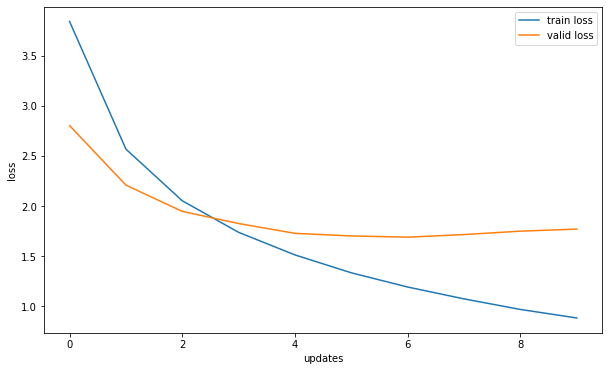

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [47]:
def translate_sentence(sentence, model, device, max_len = 50):

    model.eval()
    src_tensor = text_transform[SRC_LANGUAGE](sentence)
    # src_tensor = [src len]
    
    src_len = torch.tensor([len(src_tensor)])
    # src_len = [1]
    
    src_tensor = torch.LongTensor(src_tensor).unsqueeze(0).to(device)
    # src_tensor = [1, src len]
    
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    
    trg_indexes = [SOS_IDX]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == EOS_IDX:
            break
        
    #convert integer back to string
    trg_tokens = vocab_transform[TRG_LANGUAGE].lookup_tokens(trg_indexes)
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [48]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')
        
        tokens = token_transform[SRC_LANGUAGE](sentence)

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in tokens]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Then we'll finally start translating some sentences.

First, we'll get an example from the training set:

In [50]:
valid_iter = Multi30k(split=('valid'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
sample = next(valid_iter)

In [51]:
#de
sentence = sample[0]
sentence = sentence.rstrip("\n")
sentence

'Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen'

In [52]:
#de
sentence = sample[0]
sentence = sentence.rstrip("\n")
sentence

'Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen'

Then we pass it into our `translate_sentence` function which gives us the predicted translation tokens as well as the attention.

In [53]:
translation, attention = translate_sentence(sentence, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['A', 'group', 'of', 'men', 'loading', 'a', 'truck', 'on', 'a', 'truck', '.', '<eos>']


In [54]:
translation, attention = translate_sentence(sentence, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['A', 'group', 'of', 'men', 'loading', 'a', 'truck', 'on', 'a', 'truck', '.', '<eos>']


We can view the attention of the model, making sure it gives sensibile looking results.

/tmp/ipykernel_534/1800375771.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in tokens]+['<eos>'],
/tmp/ipykernel_534/1800375771.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


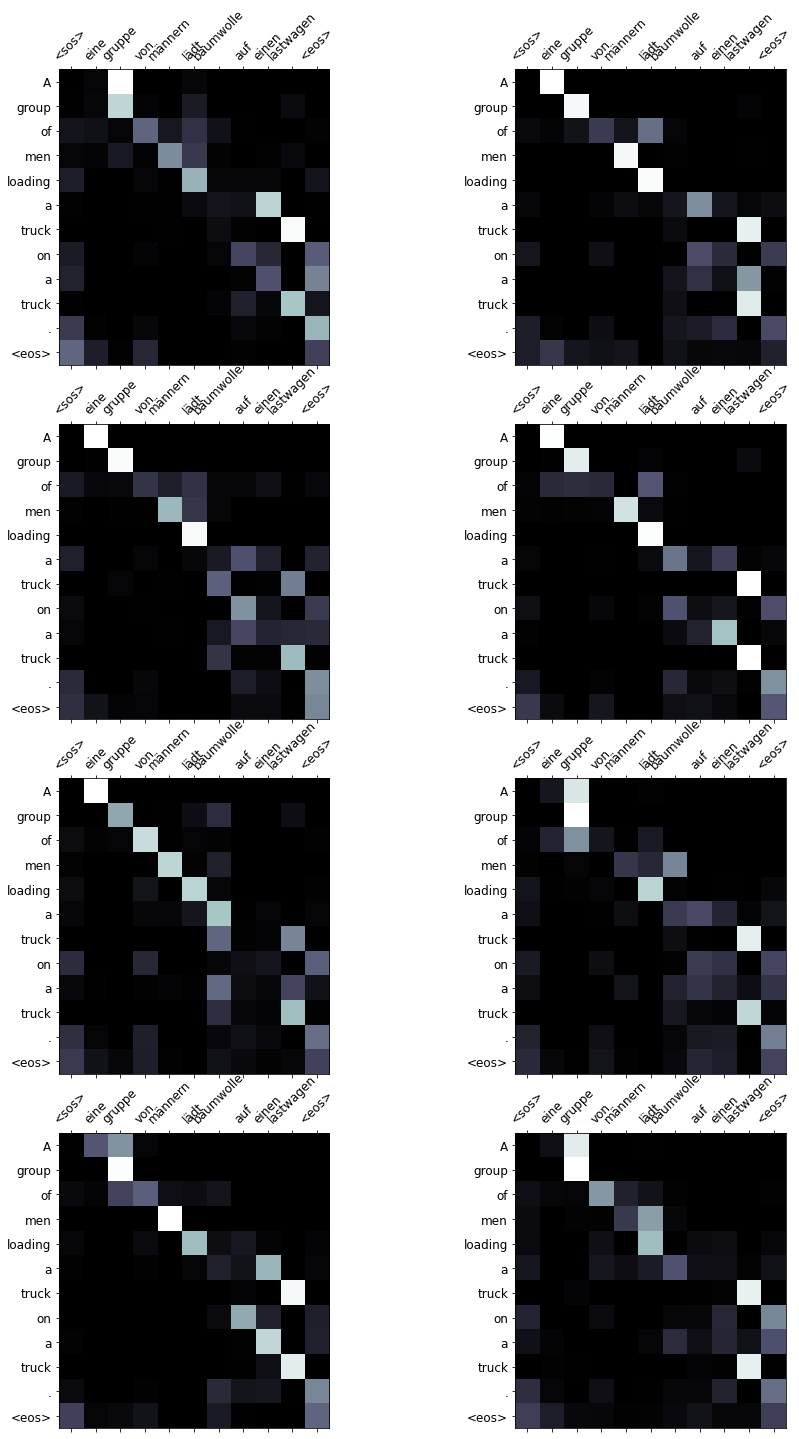

In [57]:
display_attention(sentence, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

#### Please explain what BLEU score is, its pros and cons and what are other scores available that can be used instead of BLEU?
#### <font color="red">Write your answer here.</font> 

In [55]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(iterator, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for src, trg in iterator:
        
        pred_trg, _ = translate_sentence(src, model, device, max_len)
                
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        #tokenize target sentence so it can be compared with pred_trgs
        trg = token_transform[TRG_LANGUAGE](trg.rstrip("\n"))

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 32.57, all this whilst having the least amount of parameters and the fastest training time!  The paper has a higher BLEU because they have trained for longer, but I think this is enough for us :-)

In [56]:
test_iter = Multi30k(split=('test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
bleu_score = calculate_bleu(test_iter, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 32.57


### Reference:
https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/#:~:text=If%20you%20are%20working%20on,stemming%20and%20stop%20word%20removal.